In [7]:
# $ pip install ipympl
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

[[534.80326845   0.         335.68643204]
 [  0.         534.80326845 240.66183054]
 [  0.           0.           1.        ]]


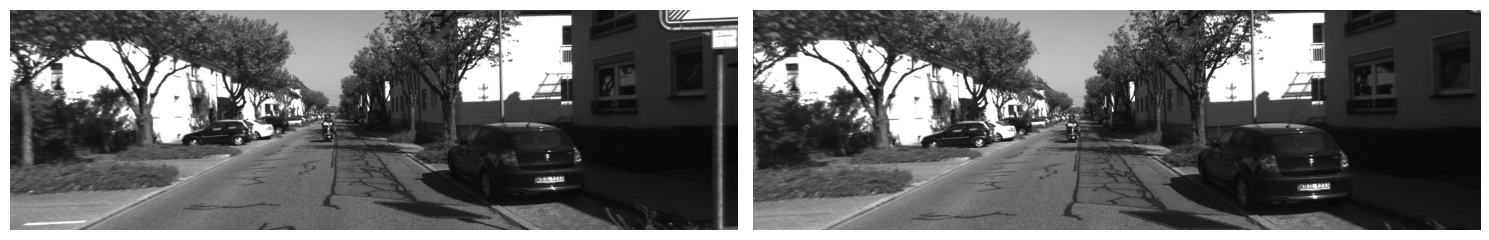

In [2]:
img_dir = '../dataset/kitti_00'
calibration_dir = '../dataset/intrinsics.yml'

img1 = cv2.imread(img_dir + '/000000.png')
img2 = cv2.imread(img_dir + '/000001.png')

def get_camera_intrinsic_matrix(calibration_dir):
    calibration_file = cv2.FileStorage(calibration_dir, cv2.FILE_STORAGE_READ)
    matrix = np.array(calibration_file.getNode('M1').mat())
    calibration_file.release()
    return matrix

K = get_camera_intrinsic_matrix(calibration_dir)
print(K)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()


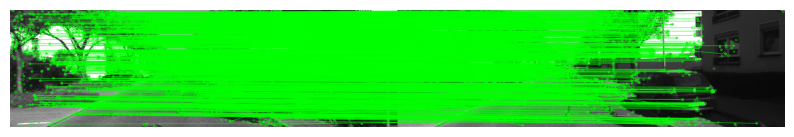

In [3]:
def get_matches_pts(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # cacula os matches entre os descritores a partir do algoritmo K-D Tree
    index_params = dict(algorithm = 1, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # filtra alguns valores de matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # pega os pontos correspondentes
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    return src_pts, dst_pts, good_matches, kp1, kp2

src_pts, dst_pts, good_matches, kp1, kp2 = get_matches_pts(img1, img2)

# desenha os matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, matchColor=(0, 255, 0), singlePointColor=(0, 255, 0))
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

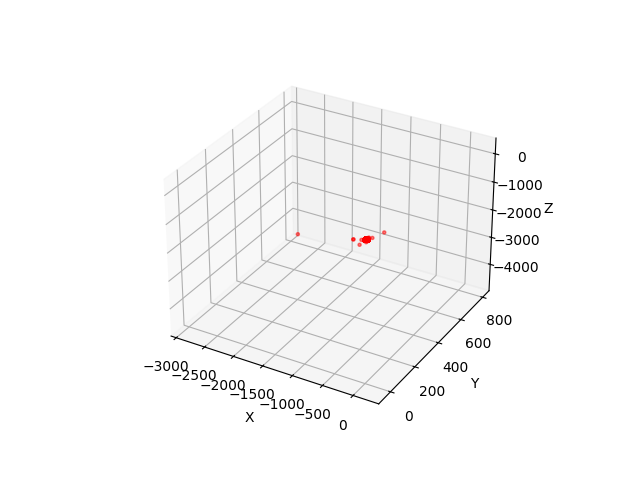

In [5]:
E, mask = cv2.findEssentialMat(src_pts, dst_pts, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

_, R, t, _ = cv2.recoverPose(E, src_pts, dst_pts, K, mask=mask)

def triangulate_points(src_pts, dst_pts, K, R, t):
    # Build the projection matrices for the two cameras
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R, t))

    # Convert the projection matrices to the camera coordinate system
    P1 = K @ P1
    P2 = K @ P2

    # Triangulate the 3D points
    points_4D = cv2.triangulatePoints(P1, P2, src_pts, dst_pts)
    points_3D = points_4D / points_4D[3]  # Convert from homogeneous to Cartesian coordinates
    points_3D = points_3D[:3, :].T

    return points_3D

points_3D = triangulate_points(src_pts, dst_pts, K, R, t)   

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='o', s=5, c='r', alpha=0.5)
%matplotlib widget
# Configure the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

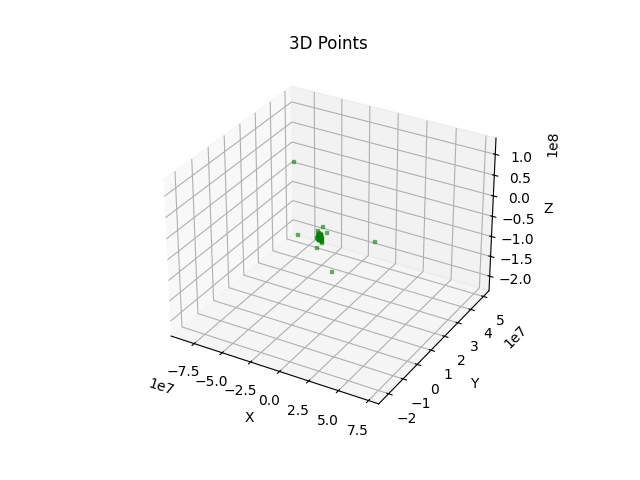

In [31]:

def align_points(points_3D, good_matches, dst_pts):
    aligned_3D = []
    aligned_2D = []

    for i, match in enumerate(good_matches):
        query_idx = match.queryIdx

        if query_idx < len(points_3D):  # Garantir que há um ponto 3D correspondente
            aligned_3D.append(points_3D[query_idx])  # Adicionar ponto 3D
            aligned_2D.append(dst_pts[i])  # Adicionar ponto 2D filtrado

    # Converter para formato adequado
    aligned_3D = np.array(aligned_3D, dtype=np.float32)
    aligned_2D = np.array(aligned_2D, dtype=np.float32)

    return aligned_3D, aligned_2D


def structure_reconstrution(points_3D, K, img_dir):
    image_files = glob.glob(img_dir + '/*.png')
    image_files = sorted(image_files)

    img_old = cv2.imread(image_files[1])
    camera_positions = []
    for image_path in image_files[2::]:
        new_img = cv2.imread(image_path)

        src_pts, dst_pts, good_matches, _, _ = get_matches_pts(img_old, new_img)
        aligned_3D, aligned_2D = align_points(points_3D, good_matches, dst_pts)

        _, rvec, tvec = cv2.solvePnP(aligned_3D, aligned_2D, K, None)
        R, _ = cv2.Rodrigues(rvec)

        new_points_3D = triangulate_points(src_pts, dst_pts, K, R, tvec)

        img_old = new_img

        points_3D = np.vstack([points_3D, new_points_3D])

        new_camera_position = -np.dot(R.T, tvec)
        camera_positions.append(new_camera_position)

    camera_positions = np.array(camera_positions).reshape(-1, 3)
    return points_3D, camera_positions

points_3D, camera_positions = structure_reconstrution(points_3D, K, img_dir)

%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], marker='s', s=5, c='g', alpha=0.5)
plt.title('3D Points')
# Configure the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()




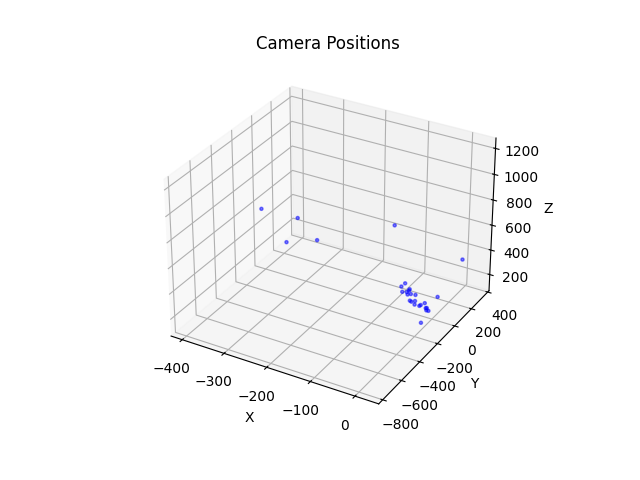

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points
ax.scatter(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2], marker='o', s=5, c='b', alpha=0.5)
# Configure the plot
plt.title('Camera Positions')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()